# Referencias:

Blog de keras:
https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

Paper de google:
https://arxiv.org/abs/1409.3215

# Sequencia a Secuencia (Seq2Seq)
https://youtu.be/HPOzAlXhuxQ

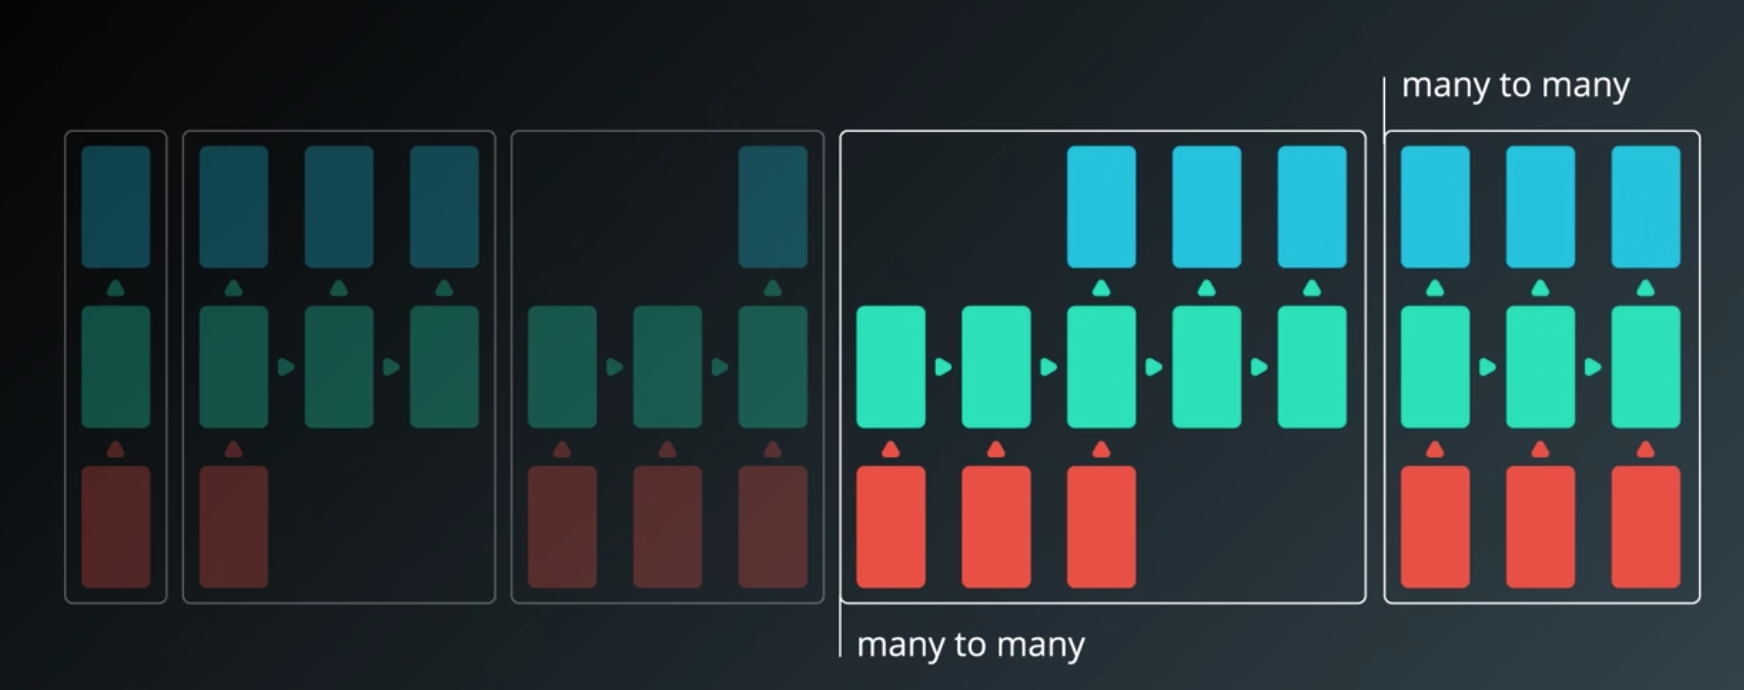

Sería conveniente:
- La longitud de la secuencia de entrada pueda diferir de la de salida
- Leer toda la secuencia de entrada antes de que empecemos a calcular la secuencia de salida

¿Cual de las dos soluciones se ajusta mejor?

## Aplicaciones:
- Traducción
- Chatbots
- Speech2Text
- Síntesis de noticias
- Q&A
- Image Captioning (Estrictamente la entrada no es una secuencia si no una imagen)

## Modelo encoder-decoder

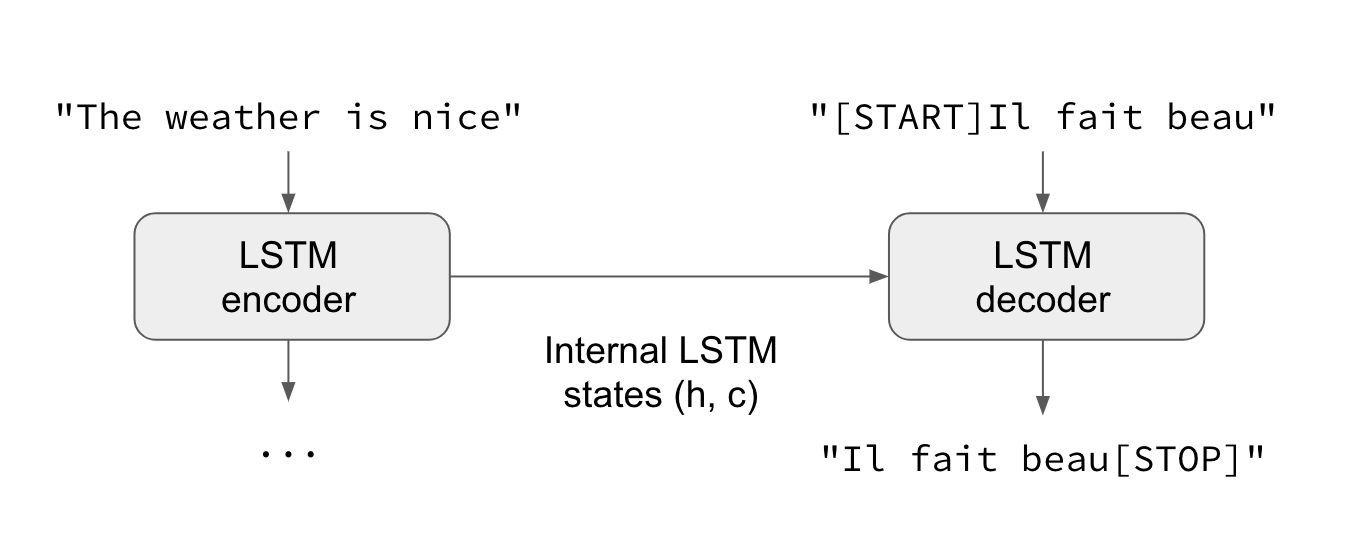

### Encoder:
- Procesa la secuencia de entrada y devuelve su estado interno
- Normalmente LSTM o GRU
- ¿Cual es la diferencia entre el estado interno y la salida? En SimpleRNN y GRU coinciden, en LSTM es antes de aplicar tanh
- Este estado interno se llama contexto y es lo que condicionara el decodificador

### Decoder:

- Se entrena para predecir la salida del próximo timestep en función del anterior.
- El estado inicial es el estado interno del encoder.
- Al proceso de entrenamiento se lo llama "teacher forcing"
- Es decir, la salida en T+1 la obtiene en funcion de la entrada en T, partiendo del estado inicial del final del encoder


El decoder se puede pensar como un **modelo de lenguage generador** con ciertas condiciones de entorno que generan un contexto. Ese contexto puede haber sido generado por:
- Una imagen
- Un texto a traducir
- Una pregunta en Q&A
- Una noticia
- Una señal de voz
Que fue procesada/o y aplicado a la LSTM o GRU del Encoder

La salida será:
- Un texto que describe la imagen
- La traducción del texto original
- Etc

Ver video:
https://www.youtube.com/watch?v=IxQtK2SjWWM&t=165s

Por que no se usan RNN tradicional y se usa LSTM o GRU? 

- Se espera que en el hidden state que queda como estado inicial, quede guardado **toda la info de la oración hasta el final**. 
- Una posible solución es colocar el estado inicial en cada timestep del decoder o focalizar en un sector (**Attention**)
- Vanilla Seq2Seq funciona bien en oraciones cortas, por eso aparece Attention

### Inferencia (caracter por caracter)

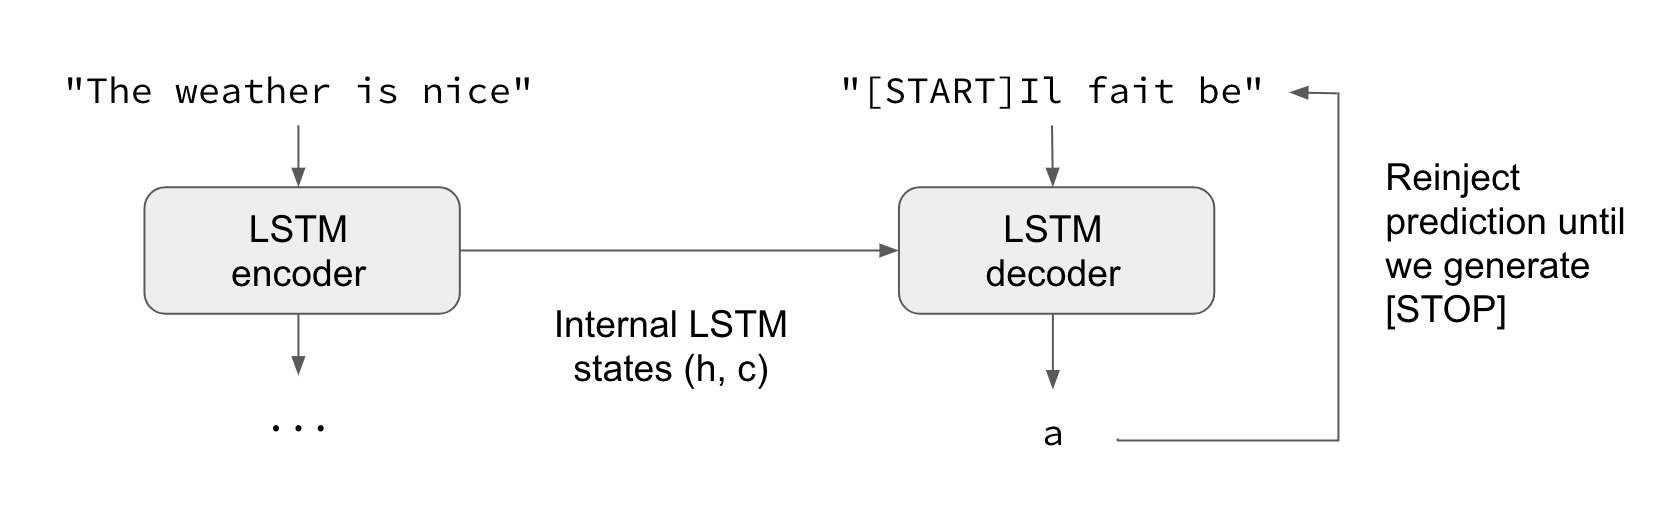

- Codificamos la secuencia de entrada con el encoder para obtener el contexto
- Utilizamos un caracter de comienzo y se lo damos como entrada al decoder junto con el contexto
- Muestramos la salida para obtener el siguiente caracter (usamos argmax).
- Agregamos el caracter de salida como parte de la secuencia de entrada y repetimos el proceso hasta que obtenemos el caracter de fin

## Ejemplo en keras: Traducción

Performance de machine translation:
http://www.meta-net.eu/events/meta-forum-2016/slides/09_sennrich.pdf

**Modelo multilenguaje**: **Google** esta desarrollando un modelo Multilenguaje donde la traducción es de cualquier idioma a cualquier idioma. Es decir, el hidden state es lo suficiente general que puede generar traducciones razonables sin haber sido entrenado en un par de idiomas:

Ingles -> Portugues
Portugues -> Español

Funciona razonablemente bien Ingles->Español y si se lo entrena con un dataset pequeño, logra performance state-of-the-art

### Obtenemos y formateamos datos

In [6]:
import numpy as np
# Función que devuelve datos formateados
def get_data(data_path = 'fra-eng/fra.txt', num_samples = 10000):
    # num_samples: Number of samples to train on.
    # Vectorize the data.
    input_texts = []
    target_texts = []
    input_characters = set()
    target_characters = set()
    lines = open(data_path).read().split('\n')
    for line in lines[: min(num_samples, len(lines) - 1)]:
        input_text, target_text = line.split('\t')
        # We use "tab" as the "start sequence" character
        # for the targets, and "\n" as "end sequence" character.
        target_text = '\t' + target_text + '\n'
        input_texts.append(input_text)
        target_texts.append(target_text)
        for char in input_text:
            if char not in input_characters:
                input_characters.add(char)
        for char in target_text:
            if char not in target_characters:
                target_characters.add(char)
    input_characters = sorted(list(input_characters))
    target_characters = sorted(list(target_characters))
    num_encoder_tokens = len(input_characters)
    num_decoder_tokens = len(target_characters)
    input_lenghts = [len(txt) for txt in input_texts]
    output_lengths = [len(txt) for txt in target_texts]
    max_encoder_seq_length = max(input_lenghts)
    max_decoder_seq_length = max(output_lengths)
    print('Traducción con secuencia mas larga (Notar el agregado de tab y enter):')
    print(input_texts[np.argmax(output_lengths)])
    print(target_texts[np.argmax(output_lengths)])

    print('Number of samples:', len(input_texts))
    print('Number of unique input tokens:', num_encoder_tokens)
    print('Number of unique output tokens:', num_decoder_tokens)
    print('Max sequence length for inputs:', max_encoder_seq_length)
    print('Max sequence length for outputs:', max_decoder_seq_length)

    input_token_index = dict(
        [(char, i) for i, char in enumerate(input_characters)])
    target_token_index = dict(
        [(char, i) for i, char in enumerate(target_characters)])
    encoder_input_data = np.zeros(
        (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
        dtype='float32')
    decoder_input_data = np.zeros(
        (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
        dtype='float32')
    decoder_target_data = np.zeros(
        (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
        dtype='float32')

    for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
        for t, char in enumerate(input_text):
            encoder_input_data[i, t, input_token_index[char]] = 1.
        for t, char in enumerate(target_text):
            # decoder_target_data is ahead of decoder_input_data by one timestep
            decoder_input_data[i, t, target_token_index[char]] = 1.
            if t > 0:
                # decoder_target_data will be ahead by one timestep
                # and will not include the start character.
                decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    return encoder_input_data, decoder_input_data, decoder_target_data, \
            input_token_index, target_token_index, \
            num_encoder_tokens, num_decoder_tokens, \
            max_encoder_seq_length, max_decoder_seq_length, \
            input_texts, target_texts

In [3]:
num_samples = 10000
encoder_input_data, decoder_input_data, decoder_target_data, \
input_token_index, target_token_index, \
num_encoder_tokens, num_decoder_tokens,  \
max_encoder_seq_length, \
max_decoder_seq_length, \
input_texts, target_texts = get_data(num_samples = 10000)

Traducción con secuencia mas larga (Notar el agregado de tab y enter):
I got carded.
	On m'a demandé ma carte d'identité pour vérifier mon âge.

Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 93
Max sequence length for inputs: 16
Max sequence length for outputs: 59


In [4]:
print(encoder_input_data.shape)
print(decoder_input_data.shape)
print(decoder_target_data.shape)

(10000, 16, 71)
(10000, 59, 93)
(10000, 59, 93)


¿Cuál es la diferencia entre **decoder_input_data** y **decoder_target_data**?

### Definicion del modelo

Estados:

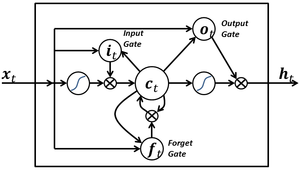

In [5]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, TimeDistributed
# Estamos utilizando la Functional API

# Esto es donde guardará el contexto
latent_dim = 256  # Latent dimensionality of the encoding space.

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens), name="Encoder_Inputs") #num_encoder_tokens es la cantidad de features a la entrada
encoder = LSTM(latent_dim, return_state=True, name="Encoder_LSTM")
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens), name="Dencoder_Inputs") #num_decoder_tokens es la cantidad de features a la entrada del decoder
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the 
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, name="Decoder_LSTM")
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax', name='Model_Output')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
Encoder_Inputs (InputLayer)      (None, None, 71)      0                                            
____________________________________________________________________________________________________
Dencoder_Inputs (InputLayer)     (None, None, 93)      0                                            
____________________________________________________________________________________________________
Encoder_LSTM (LSTM)              [(None, 256), (None,  335872      Encoder_Inputs[0][0]             
____________________________________________________________________________________________________
Decoder_LSTM (LSTM)              [(None, None, 256), ( 358400      Dencoder_Inputs[0][0]            
                                                                   Encoder_LSTM[0][1]      

### Entrenamos el modelo

In [35]:
# Run training
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.

model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 141s - loss: 0.9299 - val_loss: 0.9911
Epoch 2/100
8000/8000 [==============================] - 124s - loss: 0.7412 - val_loss: 0.7995
Epoch 3/100
8000/8000 [==============================] - 123s - loss: 0.6276 - val_loss: 0.7429
Epoch 4/100
8000/8000 [==============================] - 122s - loss: 0.5706 - val_loss: 0.6670
Epoch 5/100
8000/8000 [==============================] - 126s - loss: 0.5304 - val_loss: 0.6346
Epoch 6/100
8000/8000 [==============================] - 125s - loss: 0.4975 - val_loss: 0.6101
Epoch 7/100
8000/8000 [==============================] - 124s - loss: 0.4700 - val_loss: 0.5844
Epoch 8/100
8000/8000 [==============================] - 122s - loss: 0.4462 - val_loss: 0.5722
Epoch 9/100
8000/8000 [==============================] - 122s - loss: 0.4258 - val_loss: 0.5538
Epoch 10/100
8000/8000 [==============================] - 122s - loss: 0.4079 - val_loss

8000/8000 [==============================] - 119s - loss: 0.0704 - val_loss: 0.7300
Epoch 86/100
8000/8000 [==============================] - 119s - loss: 0.0695 - val_loss: 0.7350
Epoch 87/100
8000/8000 [==============================] - 119s - loss: 0.0685 - val_loss: 0.7358
Epoch 88/100
8000/8000 [==============================] - 119s - loss: 0.0675 - val_loss: 0.7351
Epoch 89/100
8000/8000 [==============================] - 118s - loss: 0.0664 - val_loss: 0.7462
Epoch 90/100
8000/8000 [==============================] - 119s - loss: 0.0659 - val_loss: 0.7471
Epoch 91/100
8000/8000 [==============================] - 119s - loss: 0.0646 - val_loss: 0.7530
Epoch 92/100
8000/8000 [==============================] - 119s - loss: 0.0639 - val_loss: 0.7585
Epoch 93/100
8000/8000 [==============================] - 119s - loss: 0.0630 - val_loss: 0.7622
Epoch 94/100
8000/8000 [==============================] - 119s - loss: 0.0620 - val_loss: 0.7669
Epoch 95/100
8000/8000 [===================

In [36]:
model.save_weights('seq2seq_enc_dec_model.hdf5')

### Inference Model

In [37]:
print([decoder_inputs] + decoder_states_inputs)

[<tf.Tensor 'Dencoder_Inputs_10:0' shape=(?, ?, 93) dtype=float32>, <tf.Tensor 'State_input_h:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'State_input_c:0' shape=(?, 256) dtype=float32>]


In [38]:
print([decoder_outputs] + decoder_states)

[<tf.Tensor 'Model_Output_4/truediv:0' shape=(?, ?, 93) dtype=float32>, <tf.Tensor 'Decoder_LSTM_11/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'Decoder_LSTM_11/while/Exit_3:0' shape=(?, 256) dtype=float32>]


In [39]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,), name="State_input_h")
decoder_state_input_c = Input(shape=(latent_dim,), name="State_input_c")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [40]:
encoder_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoder_Inputs (InputLayer)  (None, None, 71)          0         
_________________________________________________________________
Encoder_LSTM (LSTM)          [(None, 256), (None, 256) 335872    
Total params: 335,872
Trainable params: 335,872
Non-trainable params: 0
_________________________________________________________________


In [41]:
decoder_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
Dencoder_Inputs (InputLayer)     (None, None, 93)      0                                            
____________________________________________________________________________________________________
State_input_h (InputLayer)       (None, 256)           0                                            
____________________________________________________________________________________________________
State_input_c (InputLayer)       (None, 256)           0                                            
____________________________________________________________________________________________________
Decoder_LSTM (LSTM)              [(None, None, 256), ( 358400      Dencoder_Inputs[0][0]            
                                                                   State_input_h[0][0]     

### Decoding

In [42]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

In [43]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]
    return decoded_sentence

In [48]:
for seq_index in range(100):
    # Take one sequence (part of the training test)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: Go.
Decoded sentence: Va !

-
Input sentence: Run!
Decoded sentence: Courez !

-
Input sentence: Run!
Decoded sentence: Courez !

-
Input sentence: Wow!
Decoded sentence: Ça alors !

-
Input sentence: Fire!
Decoded sentence: Au feu !

-
Input sentence: Help!
Decoded sentence: À l'aide !

-
Input sentence: Jump.
Decoded sentence: Saute.

-
Input sentence: Stop!
Decoded sentence: Arrête-toi !

-
Input sentence: Stop!
Decoded sentence: Arrête-toi !

-
Input sentence: Stop!
Decoded sentence: Arrête-toi !

-
Input sentence: Wait!
Decoded sentence: Attendez !

-
Input sentence: Wait!
Decoded sentence: Attendez !

-
Input sentence: I see.
Decoded sentence: Je te les aimé.

-
Input sentence: I try.
Decoded sentence: J'essaye.

-
Input sentence: I won!
Decoded sentence: J'y suis allée deux fois.

-
Input sentence: I won!
Decoded sentence: J'y suis allée deux fois.

-
Input sentence: Oh no!
Decoded sentence: Oh non !

-
Input sentence: Attack!
Decoded sentence: Attaque !

-
Inp

### Se esta usando argmax. Se podría mejorar? Como?
- Viterbi?
- Stocastich Beam Search
- Simulated Annealing
- Greedy Search

### Comentar opciones con words embeddings, GRU y sin Teach forcing
https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

## Interesante:

Facebook saco un modelo de traducción con CNNs:

https://s3.amazonaws.com/fairseq/papers/convolutional-sequence-to-sequence-learning.pdf

https://datawarrior.wordpress.com/2017/05/11/convnet-seq2seq-for-machine-translation/

Paper de Google de 2016 sobre traducción:

https://arxiv.org/abs/1609.08144